<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Forms-and-Quantification-of-Bias-in-AI/Practice_2_Evaluate_fairness_metrics_manually.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 3: Sources, Forms, and Quantification of Bias and Discrimination in Supervised Learning**
## **PRACTICE NOTEBOOK 2 - Evaluate model bias "manually"**


In this part of the course, we will look for bias using a practical example. A  company is looking to hire a new employee. They use a machine learning algorithm to select the top candidates. The candidates are assigned either 0 if they're not selected or 1 if they are.

There are 4 practice notebooks in total (current one in red):
1. Explore given data to: detect potential bias early & check for proxies
2. <font color='red'> **Evaluate model bias "manually"**</font>
3. Evaluate model bias using **holisticai** library
4. Example code to get confidence intervals for a metric (nothing to do)

Instructions to complete in each parts are in bold. Intermediate results are given so one can continue the exercise.

This is notebook number 2.

Up to this point, we haven't used any model yet and simply analysed the dataset used for training. We haven't used any fairness metrics either, but we can already see a few points that are warning signs. The first one is that the average success rate within the training data differs for various ethnicities (Asian : 0.32, Black : 0.35, Hispanic : 0.38 , White : 0.39). If there was no proxies at all for ethnicity in the data, it would be fine to train with this data as ethnicity would have zero influence on the result. Unfortunately, we have seen that it is not the case. We can therefore expect there might be some bias on a model trained on this data.

Note that in a more thorough experiment, we would test fairness using cross-validation or bootsampling methods (see section 10.2 from this book), giving us more trustworthy average figures for each metric (for accuracy and fairness). In this course, we do the analysis on one single random split of the data, hence yielding only one figure. Example code to obtain a confidence interval is provided in practice notebook 4.

We evaluate two types of metrics:

- Equality of outcome metrics: These measure the distribution of positive outcomes with respect to the protected characteristic. We focus on this when we would like our model to predict an equal proportion of positive outcomes for the protected group compared with the rest of the population. We will estimate the two following metrics: Statistical Parity and Disparate Impact.

- Equalized Odds and Equality of Opportunity metrics. These measure the distribution of model errors with respect to the protected characteristic. These are useful when Statistical Parity is not an appropriate goal, for example where there are legitimate reasons for a protected group to have a different rate of positive outcome to the rest of the population, but where we would like to make sure the model makes the same volume and types of errors for both groups. We will estimate the following metric: Equal Opportunity Difference.

In this notebook we will:
- Split data into train/test sets, define and train a model, get overall accuracy
- Calculate the Equality of Outcome metrics *Statistical Parity* and *Disparate Impact* on the original test set
- Calculate *Statistical Parity* and *Disparate Impact* on a rebalanced test set
- Calculate the *Equal Opportunity Difference*

## **0 - Import modules, load data and useful functions**

In [143]:
#imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from imblearn import under_sampling, over_sampling
import imblearn

In [144]:
# Load data
from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
raw_data = bunch['frame']
raw_data

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Label,Gender,Ethnicity,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,Female,Black,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,...,0.513206,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617
1,1,Male,Hispanic,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,...,-1.203151,0.750136,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375
2,0,Female,Hispanic,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,...,0.249654,0.368800,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294
3,0,None,None,-1.229715,-1.342997,-0.093382,0.136900,1.195076,-0.582687,0.052355,...,0.667730,0.595494,0.454502,-0.366884,-0.399758,1.113102,0.126707,0.474569,-0.158103,1.197710
4,1,Male,Hispanic,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,...,-0.494161,0.784050,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,Female,Hispanic,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,...,-0.335082,0.709753,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563
9996,1,Male,Black,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,...,-0.562594,0.150314,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166
9997,0,Male,White,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,...,-1.204719,0.688433,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428
9998,1,Male,White,-0.526557,2.174463,-0.979082,-0.681536,-0.145515,1.703135,0.947010,...,-0.487367,2.043764,-1.570147,0.861712,-0.939181,0.090775,-1.153183,-1.362903,-1.424866,-0.374579


In [145]:
# remove all nans --> we will use the variable data (without nans) for the remaining of this notebook
data = raw_data.dropna()

In [146]:
def plot_cm(y_true,y_pred,labels = [1,0],display_labels = [1,0], ax = None):
  cm = confusion_matrix(y_true,y_pred,labels = labels)
  if ax is None:
    fig, ax = plt.subplots()
  else:
    fig = ax.figure
  sns.heatmap(cm, annot=True, ax = ax, cmap='viridis',fmt='g')

  ax.set(xticklabels=display_labels,
          yticklabels=display_labels,
          ylabel="True label",
          xlabel="Predicted label")
  return cm
def split_data_from_df(data):
  y = data['Label'].values
  # g = data['Gender'].values
  # e = data['Ethnicity'].values
  X = data[np.arange(50).astype(str)].values
  filter_col = ['Ethnicity','Gender'] + [col for col in data if str(col).startswith('Ethnicity_')] + [col for col in data if str(col).startswith('Gender_')]
  dem = data[filter_col].copy()
  return X,y,dem
def encode(df):
  g_enc = LabelEncoder()
  e_enc = LabelEncoder()
  df['Gender'] = g_enc.fit_transform(df['Gender'])
  df['Ethnicity'] = e_enc.fit_transform(df['Ethnicity'])
  return df, g_enc,e_enc
def resample_equal(df,cat):
  df['uid'] = df[cat] + df['Label'].astype(str)
  enc = LabelEncoder()
  df['uid'] = enc.fit_transform(df['uid'])
  # Resample
  uid = df['uid'].values
  res = imblearn.over_sampling.RandomOverSampler(random_state=6)
  df_res,euid = res.fit_resample(df,uid)
  df_res = pd.DataFrame(df_res,columns = df.columns)
  df_res = df_res.sample(frac=1).reset_index(drop=True)
  df_res['Label'] = df_res['Label'].astype(float)
  return df_res

## **1- Train the model & evaluate overall accuracy**

In the following code, we split the data into a train and test set, then train the model and evaluate overall accuracy.

In [147]:
# split into train/test
data_train, data_test = train_test_split(data,test_size = 0.3,random_state=4)
# get X,y,demographics for each
X_train,y_train,dem_train = split_data_from_df(data_train)
X_test,y_test,dem_test = split_data_from_df(data_test)
# define model and train
model = RidgeClassifier(random_state=42)
model.fit(X_train,y_train)
# evaluate on test
y_pred_test = model.predict(X_test)
acc = accuracy_score(y_test,y_pred_test)
print("Accuracy is %.2f"%acc)
# add predictions to data_test for simplicity of analysis
data_test = data_test.copy()
data_test['Pred'] = y_pred_test

Accuracy is 0.69


We have an overall accuracy of 0.69, let's now calculate some of the fairness metrics described in part I. We will use:

- Statistical Parity and Disparate Impact
- Equal Odds and Equal Opportunity

## **2. Calculate Statistical Parity and Disparate Impact on original test set**

**Questions** :
- **Calculate the success rate for Male, Female and White, Black, Asian, Hispanic.** Note that this is the same as the mean y value for these subsets as outcomes are either 0 or 1.

- **Calculate the Statistical Parity and Disparate Impact for:**
  - **Female vs Male**
  - **Black vs White**
  - **Asian vs White**
  - **Hispanic vs White**

As a reminder, here are the definition:
  - Statistical Parity. Difference between the success rate of the minority group with the majority group. A value below zero indicates a bias.
  - Disparate Impact. Ratio of the success rate of the minority group over the majority group. A value below 1 indicates a bias. Fairness is often considered achieved for values between 0.8 and 1.2.



In [148]:
sr_gender = data.groupby(by = ['Gender'])['Label'].mean().to_frame(name = 'Success Rate')
sr_ethnicity = data.groupby(by = ['Ethnicity'])['Label'].mean().to_frame(name = 'Success Rate')


In [149]:
outcome_metrics = pd.DataFrame(columns = ['Tested','Statistical Parity','Disparate Impact'])
outcome_metrics.set_index('Tested')
outcome_metrics.loc[len(outcome_metrics)] = ['Female vs Male', (sr_gender.loc['Male'] - sr_gender.loc['Female'])[0], (sr_gender.loc['Female']/sr_gender.loc['Male'])[0]]
outcome_metrics.loc[len(outcome_metrics)] = ['Black vs White', (sr_ethnicity.loc['White'] - sr_ethnicity.loc['Black'])[0], (sr_ethnicity.loc['Black']/sr_ethnicity.loc['White'])[0]]
outcome_metrics.loc[len(outcome_metrics)] = ['Asian vs White', (sr_ethnicity.loc['White'] - sr_ethnicity.loc['Asian'])[0], (sr_ethnicity.loc['Asian']/sr_ethnicity.loc['White'])[0]]
outcome_metrics.loc[len(outcome_metrics)] = ['Hispanic vs White', (sr_ethnicity.loc['White'] - sr_ethnicity.loc['Hispanic'])[0], (sr_ethnicity.loc['Hispanic']/sr_ethnicity.loc['White'])[0]]


In [150]:
outcome_metrics

,Tested,Statistical Parity,Disparate Impact
0,Female vs Male,-0.005561,1.014853
1,Black vs White,0.044949,0.887131
2,Asian vs White,0.072815,0.817158
3,Hispanic vs White,0.010448,0.973765


You should get the following results.

| Tested | Statistical Parity | Disparate Impact |
| --- | --- | ---|
| Female vs Male |-0.07 | 0.81 |
| Black vs White | -0.11 | 0.67 |
| Asian vs White | -0.05 | 0.86 |
| Hispanic vs White | -0.03 | 0.90 |


## **3. Calculate Statistical Parity and Disparate Impact on a rebalanced test set**

We know for the dataset analysis that the actual success rate (calculated from the ground-truth label) is lower for the *Black/Asian/Hispanic* groups compared to White group. As the test set is a random subset of the dataset, it is also likely to be true in the test set. Hence even a perfectly trained model should predict a lower success rate for those groups. To test the bias on a more balanced dataset, we resample the test set so that the success rate is equal across all groups. Note this might take a few seconds to run.


In [151]:
# resample test set so success rate equal across all groups
data_test_res = resample_equal(data_test,'Ethnicity')
X_test_res,y_test_res,dem_test_res = split_data_from_df(data_test_res)
# check success rates
print("New success rates for rebalanced test set:")
pred_e_mean_res  = data_test_res.groupby('Ethnicity').mean()['Label']
for e in pred_e_mean_res.index:
  print('   ',e,'-> %.3f'%pred_e_mean_res[e])
## evaluate model on rebalanced test set
y_pred_test_res = model.predict(X_test_res)
acc_res = accuracy_score(y_test_res,y_pred_test_res)
print("Accuracy is %.2f"%acc_res)
## add predictions to data_test for simplicity of analysis
data_test_res = data_test_res.copy()
data_test_res['Pred'] = y_pred_test_res

New success rates for rebalanced test set:
    Asian -> 0.500
    Black -> 0.500
    Hispanic -> 0.500
    White -> 0.500
Accuracy is 0.64


<ipython-input-151-441ef3388098>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_e_mean_res  = data_test_res.groupby('Ethnicity').mean()['Label']


**Questions** :
- **Repeat the steps from above to calculate the Statistical Parity and Disparate Impact on the rebalanced test set for:**
  - **Black vs White**
  - **Asian vs White**
  - **Hispanic vs White**

In [152]:
sr_ethnicity1 = data_test_res.groupby(by = ['Ethnicity'])['Label'].mean().to_frame(name = 'Success Rate')


In [153]:
outcome_metrics1 = pd.DataFrame(columns = ['Tested','Statistical Parity','Disparate Impact'])
outcome_metrics1.set_index('Tested')
outcome_metrics1.loc[len(outcome_metrics1)] = ['Black vs White', (sr_ethnicity1.loc['White'] - sr_ethnicity1.loc['Black'])[0], (sr_ethnicity1.loc['Black']/sr_ethnicity1.loc['White'])[0]]
outcome_metrics1.loc[len(outcome_metrics1)] = ['Asian vs White', (sr_ethnicity1.loc['White'] - sr_ethnicity1.loc['Asian'])[0], (sr_ethnicity1.loc['Asian']/sr_ethnicity1.loc['White'])[0]]
outcome_metrics1.loc[len(outcome_metrics1)] = ['Hispanic vs White', (sr_ethnicity1.loc['White'] - sr_ethnicity1.loc['Hispanic'])[0], (sr_ethnicity1.loc['Hispanic']/sr_ethnicity1.loc['White'])[0]]


In [154]:
outcome_metrics1

,Tested,Statistical Parity,Disparate Impact
0,Black vs White,0.0,1.0
1,Asian vs White,0.0,1.0
2,Hispanic vs White,0.0,1.0


## **4. Calculate the Equal Opportunity Difference**

In this section, we focus on the *Equal Opportunity Difference metric*. This metric is part of a wider category of metrics (Equalized Odds and Equality of opportunity) which compare performance/accuracy of predictions for different groups instead of success rates.

Equalized Odds state that the classifer should have the same True Positive Rate (TPR) and True Negative Rate (TNR) across all groups. The true positive (negative) rate is the proportion of candidates that should be successful (unsuccessful) according to ground-truth that have been correctly classified as successful (unsuccessful) by the algorithm. Mathematically, this means that the following probabilities should be equal for all groups :

$$P_{group1}(pred = \text{0 or 1} | Y = \text{0 or 1}) = P_{group2}(pred = \text{0 or 1} | Y = \text{0 or 1})$$


The figure below illustrates the definition of TPR and TNR using a confusion matrix and their relationship with the above probabilities.


<center><img src="https://drive.google.com/uc?id=1bQxfIhcrNym7UC7_yzbdaUq12qCtJ9Dr"></center>

The version of this with equal true positive rates only - i.e only looking at $P(pred = 1|y =1)$ - is called *Equal Opportunity Difference*. This measures the difference in True Positive Rates between the unprivileged and privileged group. The ideal value is 0 and fair values are often considered achieved for values between -0.1 and 0.1. In this part, we calculate the Equal Opportunity Difference for different groups.


In the following code, we split the data into a train and test set and train the model using the train set.

In [155]:
# split into train/test
data_train, data_test = train_test_split(data,test_size = 0.3,random_state=4)
# get X,y,demographics for each
X_train,y_train,dem_train = split_data_from_df(data_train)
X_test,y_test,dem_test = split_data_from_df(data_test)
# define model and train
model = RidgeClassifier(random_state=42)
model.fit(X_train,y_train)
# evaluate on test
y_pred_test = model.predict(X_test)
acc = accuracy_score(y_test,y_pred_test)
print("Accuracy is %.2f"%acc)
# add predictions to data_test for simplicity of analysis
data_test = data_test.copy()
data_test['Pred'] = y_pred_test

Accuracy is 0.69


**Questions:**
- **Compute and plot the confusion matrix for Male/Female and White/Black.** Use the pre-defined function *plot_cm(y_true,y_pred)*.
- **Compute the true positive rates for Male/Female and White/Black.**
- **Compute the Equal Opportunity Difference as the difference of the true positive rate of the unprivileged group with the privileged one:**
$EOD = TPR_{unprivileged}-TPR_{privileged}$.

array([[257, 212],
       [175, 608]])

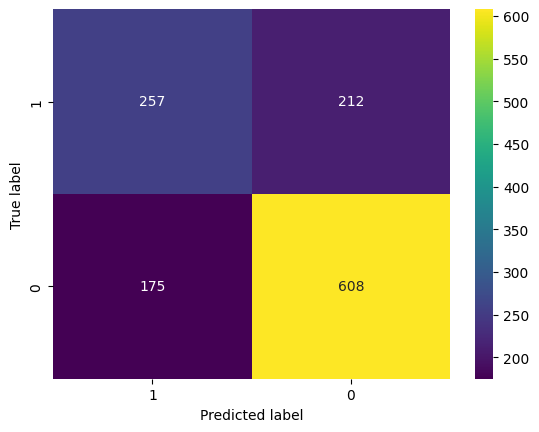

In [156]:
plot_cm(data_test[data_test['Gender'] == 'Male']['Label'], data_test[data_test['Gender'] == 'Male']['Pred'])

array([[246, 290],
       [138, 703]])

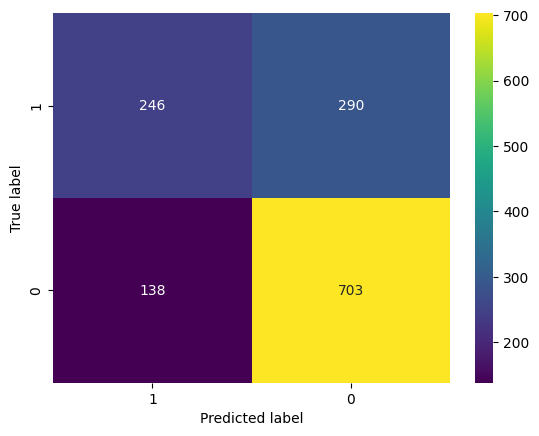

In [117]:
plot_cm(data_test[data_test['Gender'] == 'Female']['Label'], data_test[data_test['Gender'] == 'Female']['Pred'])

array([[208, 173],
       [134, 470]])

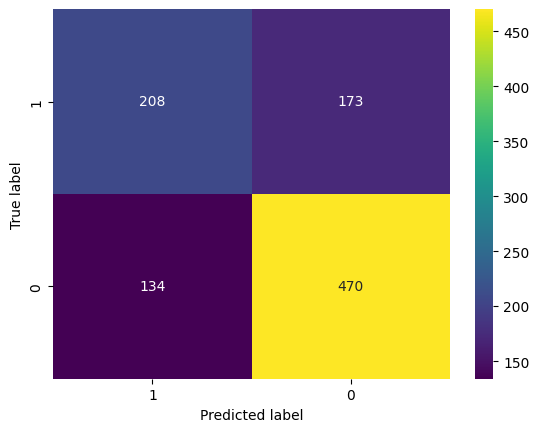

In [118]:
plot_cm(data_test[data_test['Ethnicity'] == 'White']['Label'], data_test[data_test['Ethnicity'] == 'White']['Pred'])

array([[ 65, 100],
       [ 39, 242]])

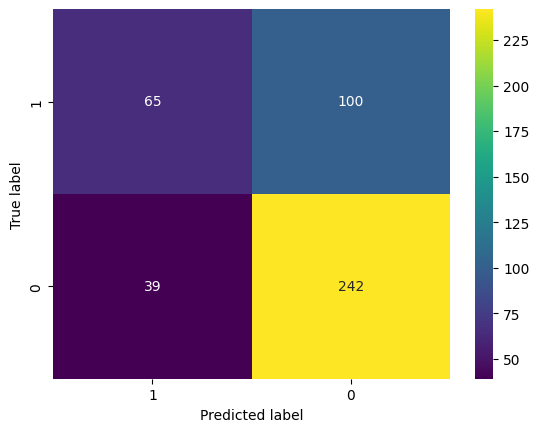

In [119]:
plot_cm(data_test[data_test['Ethnicity'] == 'Black']['Label'], data_test[data_test['Ethnicity'] == 'Black']['Pred'])

In [157]:
tpr_white = len(data_test[(data_test['Ethnicity'] == 'White') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Ethnicity'] == 'White') & (data_test['Label'] == 1)])
tpr_black = len(data_test[(data_test['Ethnicity'] == 'Black') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Ethnicity'] == 'Black') & (data_test['Label'] == 1)])
tpr_asian = len(data_test[(data_test['Ethnicity'] == 'Asian') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Ethnicity'] == 'Asian') & (data_test['Label'] == 1)])
tpr_hispanic = len(data_test[(data_test['Ethnicity'] == 'Hispanic') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Ethnicity'] == 'Hispanic') & (data_test['Label'] == 1)])
tpr_female = len(data_test[(data_test['Gender'] == 'Female') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Gender'] == 'Female') & (data_test['Label'] == 1)])
tpr_male = len(data_test[(data_test['Gender'] == 'Male') & (data_test['Pred'] == 1) & (data_test['Label'] == 1)])/len(data_test[(data_test['Gender'] == 'Male') & (data_test['Label'] == 1)])


In [158]:
EOD = pd.DataFrame(columns = ['Tested', 'Equal Opportunity Difference'])
EOD.set_index('Tested')
EOD.loc[len(EOD)] = ['Female vs Male', tpr_female - tpr_male]
EOD.loc[len(EOD)] = ['Black vs White', tpr_black - tpr_white]
EOD.loc[len(EOD)] = ['Asian vs White', tpr_asian - tpr_white]
EOD.loc[len(EOD)] = ['Hispanic vs White', tpr_hispanic - tpr_white]

In [159]:
EOD

,Tested,Equal Opportunity Difference
0,Female vs Male,-0.089019
1,Black vs White,-0.151992
2,Asian vs White,-0.078042
3,Hispanic vs White,-0.034503


You should find the following:

| Tested | Equal Opportunity Difference |
| --- | ---|
| Female vs Male | -0.09 |
| Black vs White | -0.15 |
| Asian vs White | -0.08 |
| Hispanic vs White | -0.03 |